# The Rocket Equation (1 Dimension)

To derive, start with

$$  \frac{dp}{dt} = \sum_i F_i $$

Let 

* $v(t)$ be the speed of the rocket
* $m(t)$ be the mass of the rocket 
* $v_g$ be the speed the rocket expels fuel
* $b$ be the coefficient of friction

# LHS

* **The Rocket**

$p=m(t)v(t) \implies dp = vdm + mdv$

* **The fuel coming out of the rocket**: (Note the $dm$ negative since rocket is losing mass)

$dp = -dm(v-v_g)$

* **Total**

$$dp = vdm + mdv -dm(v-v_g) = mdv + v_g dm \implies \boxed{\frac{dp}{dt} = m\frac{dv}{dt} + v_g \frac{dm}{dt}}$$

# RHS

Friction and gravity $\boxed{\sum F = -m(t) g -bv^2}$ (assuming rocket moving upwards)

# Setting LHS = RHS

After a bit of simple algebra

$$ \frac{dv}{dt} = -g -\frac{b}{m(t)}v^2 - \frac{v_g}{m(t)}\frac{dm(t)}{dt} $$

Dividing by fuel explusion speed $v_g$ and multiplying by some characteristic launch time $T_0$ yields

$$ \frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{b v_g T_0}{m(t)}v'^2 - \frac{1}{m(t)}\frac{dm(t)}{dt'} $$

where $\boxed{v'=v/v_g}$ and $\boxed{t'=t/T_0}$. Now let $\boxed{m(t) = m_0 z(t)}$ where $m_0$ is the initial mass of the rocket. If the rocket decreases to 1/10th its mass after $T_0$ it follows that $z(t'=0)=1$ and $z(t'=1) = 1/10$. Substituting this in...

$$ \frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{b v_g T_0}{m_0 z(t')}v'^2 - \frac{1}{z(t')}\frac{dz(t')}{dt'} $$

Now letting $\boxed{m_0' = m_0/bv_g T_0}$ we get

$$ \boxed{\frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{1}{m_0' z(t')}v'^2 - \frac{1}{z(t')}\frac{dz(t')}{dt'}} $$


This equation is easier since we only need to specify

* $m_0'$ contains all the information about the rocket mass, the friction force, and the rate at which fuel is expelled
* $z(t')$, the function that quantifies how fast the mass of the fuel is depleted. Here we will use $z(t') = 1-\frac{9}{10}t'^n$ so that $n$ specifies how fuel is disposed
* $v_g$, the speed at which fuel is expelled

Question: For a given $m_0'$ and $v_g$, what function $z(t')$ gets the rocket upwards to a point $h_0$ in the fastest time?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
import sympy as smp
plt.style.use(['science', 'notebook'])

Setting all our constants

In [25]:
T0 = 40 # 40 second launch
g = 9.81
vg = 500 # fuel emitted at 500m/s
M0 = 2e4 #20000kg rocket starting
b = 0.1 # coefficient of air friction
m0 = M0/(b*vg*T0)
#m0 = np.inf

In [26]:
g*T0/vg

0.7848

In [27]:
M0/(b*vg*T0)

10.0

Use sympy to define fuel loss function $z(t)$ and get derivative $dz/dt$. Then convert these into numerical python functions

In [28]:
t, n = smp.symbols('t n')
z = 1-(9/10)*t**n
z

1 - 0.9*t**n

In [29]:
t, n = smp.symbols('t n')
z = 1-(9/10)*t**n
dzdt = smp.diff(z, t).simplify()
dzdt

-0.9*n*t**(n - 1)

In [30]:
# Get numerical functions
z = smp.lambdify([t, n], z)         # same as: z = lambda t,n : 1-(9/10)*t**n
dzdt = smp.lambdify([t, n], dzdt)   # same as: dzdt = lambda t,n : -(9/10)*n*t**(n-1)

Plot a few different ways to expell fuel

In [31]:
t = np.linspace(1e-4, 1, 1000)
z1 = z(t, 1)
z2 = z(t, 0.7)
z3 = z(t, 5)

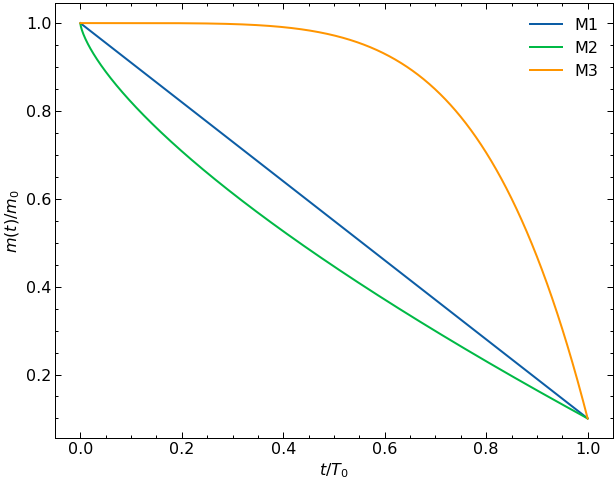

In [33]:
plt.figure(figsize=(10,8))
plt.plot(t, z1, label='M1')
plt.plot(t, z2, label='M2')
plt.plot(t, z3, label='M3')
plt.ylabel('$m(t)/m_0$')
plt.xlabel('$t/T_0$')
plt.legend()
plt.show()

Define our ODE system $\vec{S} = (x, v)$ and $d\vec{S}/dt = (dx/dt, dv/dt)$

In [35]:
T0, g, vg, M0, b, m0 

(40, 9.81, 500, 20000.0, 0.1, 10.0)

       𝑑𝑣/𝑑𝑡= −𝑔*𝑇0*𝑣𝑔 − 1/(𝑚0*𝑧(𝑡))*𝑣^2 − 1/𝑧(𝑡)*𝑑𝑧(𝑡)/𝑑𝑡

# Limited mass at start

In [131]:
T0 = 10
m0 = M0/(b*vg*T0)

In [132]:
def dSdt(t,S, m0, vg, n, T0=40):
    x, v = S[0], S[1]
    # If still have fuel left (at t=1 all fuel is expelled)
    if t<1:
        dxdt = v
        dvdt = -g*T0/vg - 1/(m0*z(t,n))*v**2 *np.sign(v) - 1/z(t, n) * dzdt(t, n)
    # If out of fuel
    else:                    
        dxdt = v
        dvdt = -g*T0/vg - 1/(m0*z(1,n))*v**2 *np.sign(v)
    # If accelerating downwards with negative speed while on the ground (can't go through ground)
    if (dvdt<0)*(dxdt<0)*(x<=0):
        dxdt=0
        dvdt=0
    return [dxdt,dvdt]

Solve for a few different ways to expell fuel

In [133]:
# from scipy.integrate import solve_ivp
n1, n2, n3 = 1, 0.7, 5.05
sol1 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n1, T0))
sol2 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n2, T0))
sol3 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n3, T0))

Plot

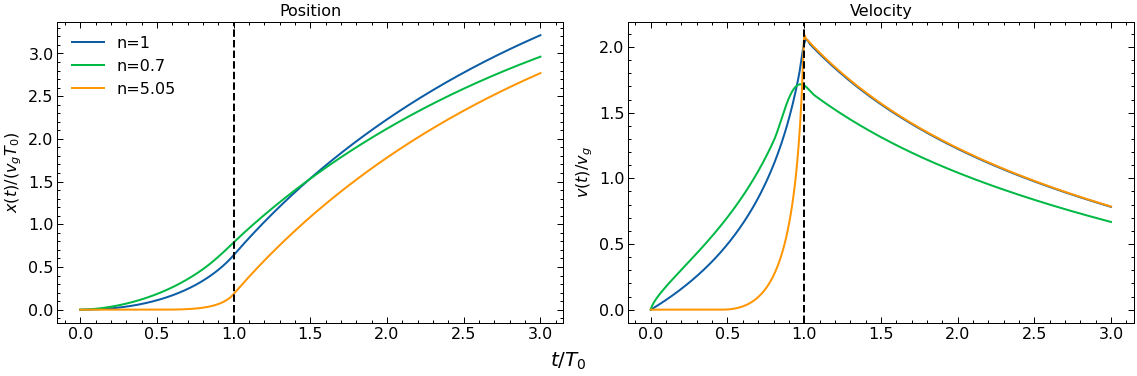

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax.plot(sol1.t, sol1.y[0], label='n={}'.format(n1))
ax.plot(sol2.t, sol2.y[0], label='n={}'.format(n2))
ax.plot(sol3.t, sol3.y[0], label='n={}'.format(n3))
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$x(t)/(v_g T_0)$')
ax.set_title('Position')
ax.legend()
ax = axes[1]
ax.plot(sol1.t, sol1.y[1], label='n=1')
ax.plot(sol2.t, sol2.y[1], label='n=0.7')
ax.plot(sol3.t, sol3.y[1], label='n=1.3')
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$v(t)/v_g$')
ax.set_title('Velocity')
fig.text(0.5, -0.04, '$t/T_0$', ha='center', fontsize=20)
fig.tight_layout()

# Varying T0

In [163]:
T0 = 10
m0 = M0/(b*vg*T0)
1/(b*vg*T0)

0.002

(40, inf, 0.0005)

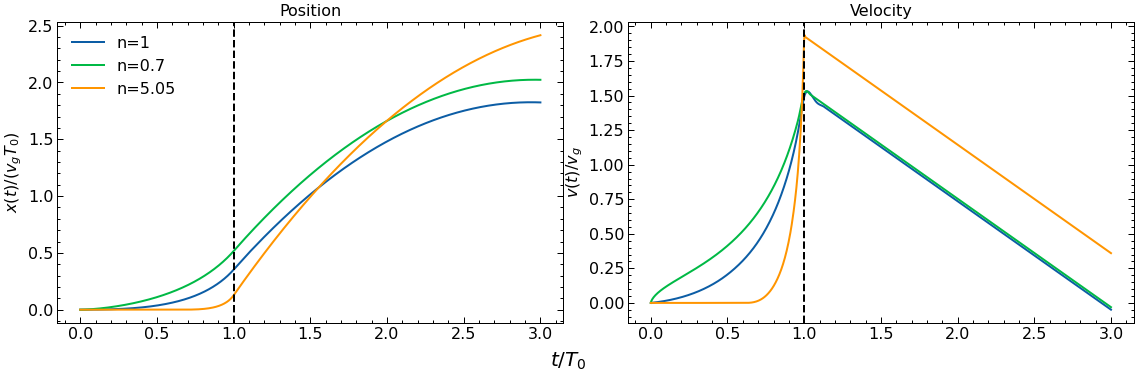

In [176]:
# infinite m0
T0 = 40
m0 = np.inf

# solve with new m0
sol1 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n1, T0))
sol2 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n2, T0))
sol3 = solve_ivp(dSdt, [1e-4, 3], y0=[0,0], t_eval=np.linspace(1e-4,3,1000), args=(m0, vg, n3, T0))

fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax.plot(sol1.t, sol1.y[0], label='n={}'.format(n1))
ax.plot(sol2.t, sol2.y[0], label='n={}'.format(n2))
ax.plot(sol3.t, sol3.y[0], label='n={}'.format(n3))
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$x(t)/(v_g T_0)$')
ax.set_title('Position')
ax.legend()
ax = axes[1]
ax.plot(sol1.t, sol1.y[1], label='n=1')
ax.plot(sol2.t, sol2.y[1], label='n=0.7')
ax.plot(sol3.t, sol3.y[1], label='n=1.3')
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$v(t)/v_g$')
ax.set_title('Velocity')
fig.text(0.5, -0.04, '$t/T_0$', ha='center', fontsize=20)
fig.tight_layout()
T0,m0,1/(b*vg*T0)

In [170]:
# it is better to expell allfuel in 40 sat the end to get higher position and velocity (orange curves)

In [183]:
# z

z = lambda t,n : 1-(9/10)*t**n

In [184]:
t = np.linspace(1e-4, 1, 1000)
z1 = z(t, 1)
z2 = z(t, 0.7)
z3 = z(t, 5)

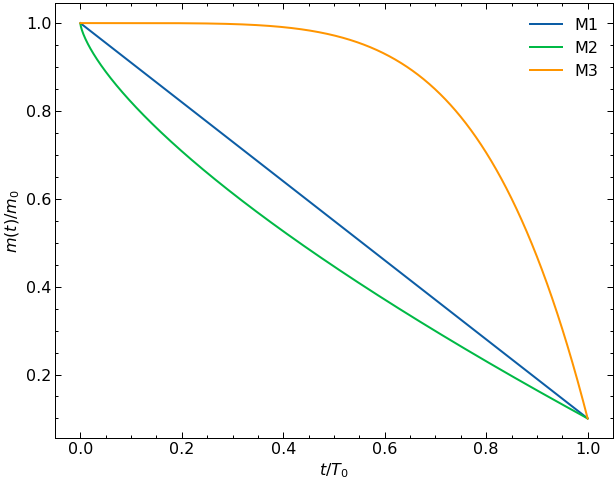

In [185]:
plt.figure(figsize=(10,8))
plt.plot(t, z1, label='M1')
plt.plot(t, z2, label='M2')
plt.plot(t, z3, label='M3')
plt.ylabel('$m(t)/m_0$')
plt.xlabel('$t/T_0$')
plt.legend()
plt.show()

In [189]:
# dzdt

dzdt = lambda t,n : -(9/10)*n*t**(n-1)

In [190]:
t = np.linspace(1e-4, 1, 1000)
z1 = dzdt(t, 1)
z2 = dzdt(t, 0.7)
z3 = dzdt(t, 5)

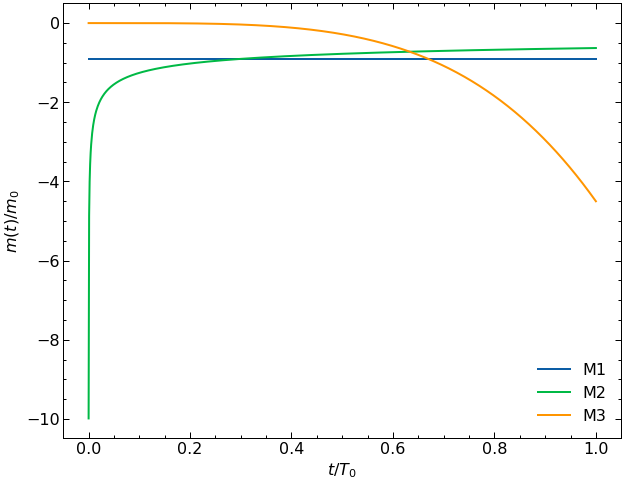

In [191]:
plt.figure(figsize=(10,8))
plt.plot(t, z1, label='M1')
plt.plot(t, z2, label='M2')
plt.plot(t, z3, label='M3')
plt.ylabel('$m(t)/m_0$')
plt.xlabel('$t/T_0$')
plt.legend()
plt.show()